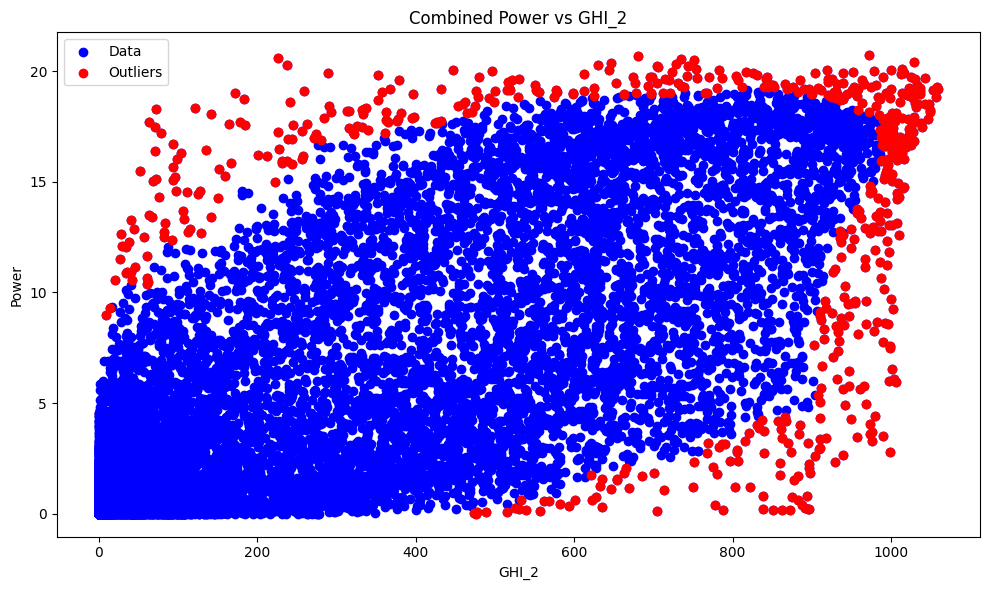

Combined data saved to /Users/maxz/Desktop/EQUOTA/outliers/combined_data.csv
Outliers data saved to /Users/maxz/Desktop/EQUOTA/outliers/combined_outliersNEW.csv
                     Date           Timestamp     Power       GHI_2
0     2023-04-30 06:00:00 2023-04-30 05:00:00  1.370923    0.000000
1     2023-04-30 06:15:00 2023-04-30 05:15:00  1.890870    0.007032
2     2023-04-30 06:30:00 2023-04-30 05:30:00  3.074107    2.962579
3     2023-04-30 06:45:00 2023-04-30 05:45:00  4.128842   22.751270
4     2023-04-30 07:00:00 2023-04-30 06:00:00  5.543221   61.385027
...                   ...                 ...       ...         ...
11216 2023-12-24 17:00:00 2023-12-24 16:00:00  0.053619  153.436642
11217 2023-12-24 17:15:00 2023-12-24 16:15:00  0.004043  106.231914
11218 2023-12-24 17:30:00 2023-12-24 16:30:00  0.000139   57.018631
11219 2023-12-24 17:45:00 2023-12-24 16:45:00  0.000139   18.337739
11220 2023-12-24 18:00:00 2023-12-24 17:00:00  0.000139    1.277499

[11172 rows x 4 column

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(data):
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)
    labels = isolation_forest.fit_predict(data)
    
    outliers = np.where(labels == -1)[0]
    return outliers

def plot_combined_data_with_outliers(power_data, ghi_data, outliers):
    plt.figure(figsize=(10, 6))
    plt.scatter(ghi_data, power_data, color='blue', label='Data')
    plt.scatter(ghi_data.iloc[outliers], power_data.iloc[outliers], color='red', label='Outliers')
    plt.xlabel('GHI_2')
    plt.ylabel('Power')
    plt.title('Combined Power vs GHI_2')
    plt.legend()
    plt.tight_layout()
    plt.savefig('combined_outliers_relationship_plot.png')
    plt.show()

def process_and_combine_files(pv_dir, gfs_dir, start_date, end_date, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    date_range = pd.date_range(start_date, end_date)
    
    combined_data = {
        "Date": [],
        "Timestamp": [],
        "Power": [],
        "GHI_2": []
    }

    for date in date_range:
        pv_file_name = f"PV_{date.strftime('%Y-%m-%d')}.csv"
        gfs_file_name = f"lat31.5_lon121.25_{date.strftime('%Y%m%d')}_gfs_15min.csv"

        pv_file_path = os.path.join(pv_dir, pv_file_name)
        gfs_file_path = os.path.join(gfs_dir, gfs_file_name)

        if os.path.exists(pv_file_path) and os.path.exists(gfs_file_path):
            pv_df = pd.read_csv(pv_file_path)
            gfs_df = pd.read_csv(gfs_file_path)

            pv_df["Date"] = pd.to_datetime(pv_df["Date"])
            gfs_df["data_time"] = pd.to_datetime(gfs_df["data_time"])
            
            pv_df = pv_df[(pv_df["Date"].dt.time >= pd.to_datetime("06:00").time()) & (pv_df["Date"].dt.time <= pd.to_datetime("18:00").time())]
            gfs_df = gfs_df[(gfs_df["data_time"].dt.time >= pd.to_datetime("05:00").time()) & (gfs_df["data_time"].dt.time <= pd.to_datetime("18:00").time())]

            if len(pv_df) != len(gfs_df):
                min_len = min(len(pv_df), len(gfs_df))
                pv_df = pv_df.iloc[:min_len]
                gfs_df = gfs_df.iloc[:min_len]

            power_data = pv_df["Power"]
            ghi_data = gfs_df["GHI_2"]

            combined_data["Date"].extend(pv_df["Date"])
            combined_data["Timestamp"].extend(gfs_df["data_time"])
            combined_data["Power"].extend(power_data)
            combined_data["GHI_2"].extend(ghi_data)
    
    combined_df = pd.DataFrame(combined_data).dropna()
    
    combined_data_points = combined_df[["Power", "GHI_2"]]
    outliers = detect_outliers_isolation_forest(combined_data_points)

    plot_combined_data_with_outliers(combined_df["Power"], combined_df["GHI_2"], outliers)

    outliers_data = combined_df.iloc[outliers].reset_index(drop=True)
    
    combined_file_path = os.path.join(output_dir, "combined_data.csv")
    outliers_file_path = os.path.join(output_dir, "combined_outliersNEW.csv")
    combined_df.to_csv(combined_file_path, index=False)
    outliers_data.to_csv(outliers_file_path, index=False)
    print(f"Combined data saved to {combined_file_path}")
    print(f"Outliers data saved to {outliers_file_path}")

    return combined_df, outliers_data

pv_directory = '/Users/maxz/Desktop/EQUOTA/光伏/processed/PV/罗泾'
gfs_directory = '/Users/maxz/Desktop/EQUOTA/光伏/gfs_processed'
output_directory = '/Users/maxz/Desktop/EQUOTA/outliers'

start_date = '2023-04-30'
end_date = '2023-12-30'

combined_df, outliers_df = process_and_combine_files(pv_directory, gfs_directory, start_date, end_date, output_directory)

print(combined_df)
print(outliers_df)
